# **1. Import Library**

In [1]:
import os
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# **2. Load Dataset**

In [2]:
df = pd.read_csv('/content/CF.csv')

# **3. EDA**

count    23900.000000
mean         3.020418
std          1.414924
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64


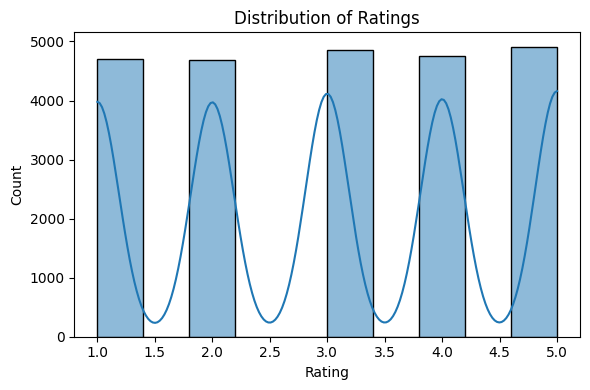

In [3]:
print(df['rating'].describe())
plt.figure(figsize=(6,4))
sns.histplot(df['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [4]:
# Interaksi per user/item
users_count = df['user_id'].value_counts().head(10)
items_count = df['item_id'].value_counts().head(10)
print("Top 10 users by interactions:\n", users_count)
print("Top 10 items by interactions:\n", items_count)

Top 10 users by interactions:
 user_id
user001    239
user002    239
user003    239
user004    239
user005    239
user006    239
user007    239
user008    239
user009    239
user010    239
Name: count, dtype: int64
Top 10 items by interactions:
 item_id
Wisata Alam Datuk                100
WISATA ALAM KASIH                100
Taman Wisata Alam Sibolangit     100
Wisata Alam Sikabung-kabung      100
Bukit Indah Simarjarunjung       100
Bukit Sipisopiso                 100
Air Terjun Sigura-Gura           100
Taman Alam Lumbini Berastagi     100
Wisata Batu Katak                100
Kawah Putih Dolok Tinggi Raja    100
Name: count, dtype: int64


# **4. Preprocessing: Label Encoding**

In [5]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df['user_idx'] = user_encoder.fit_transform(df['user_id'])
df['item_idx'] = item_encoder.fit_transform(df['item_id'])

num_users = df['user_idx'].nunique()
num_items = df['item_idx'].nunique()
print(f"🔢 Users: {num_users}, Items: {num_items}")

🔢 Users: 100, Items: 239


# **5. Data Splitting**

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
BATCH_SIZE = 64

def df_to_tf_dataset(dataframe):
    ds = tf.data.Dataset.from_tensor_slices(({
        'user_idx': dataframe['user_idx'].values,
        'item_idx': dataframe['item_idx'].values
    }, dataframe['rating'].values.astype(np.float32)))
    return ds.shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = df_to_tf_dataset(train_df)
test_ds = df_to_tf_dataset(test_df)

# **6. Model Building**

In [8]:
EMBEDDING_SIZE = 32
L2_REG = 1e-6

# Inputs
user_input = tf.keras.layers.Input(shape=(), name='user_idx', dtype=tf.int32)
item_input = tf.keras.layers.Input(shape=(), name='item_idx', dtype=tf.int32)

# Embeddings + regularizer
user_emb = tf.keras.layers.Embedding(
    input_dim=num_users,
    output_dim=EMBEDDING_SIZE,
    embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
    name='user_emb'
)(user_input)

item_emb = tf.keras.layers.Embedding(
    input_dim=num_items,
    output_dim=EMBEDDING_SIZE,
    embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
    name='item_emb'
)(item_input)

# Bias terms
user_bias = tf.keras.layers.Embedding(num_users, 1, name='user_bias')(user_input)
item_bias = tf.keras.layers.Embedding(num_items, 1, name='item_bias')(item_input)

# Flatten all
user_vec  = tf.keras.layers.Flatten()(user_emb)
item_vec  = tf.keras.layers.Flatten()(item_emb)
user_b    = tf.keras.layers.Flatten()(user_bias)
item_b    = tf.keras.layers.Flatten()(item_bias)

# Dot + bias → output
dot = tf.keras.layers.Dot(axes=1)([user_vec, item_vec])
x   = tf.keras.layers.Add()([dot, user_b, item_b])
output = tf.keras.layers.Activation('linear')(x)

model = tf.keras.Model(inputs=[user_input, item_input], outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_idx            │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_idx            │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_emb            │ (None, 32)        │      3,200 │ user_idx[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_emb            │ (None, 32)        │      7,648 │ item_idx[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ user_emb[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ item_emb[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_bias           │ (None, 1)         │        100 │ user_idx[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_bias           │ (None, 1)         │        239 │ item_idx[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1)         │          0 │ user_bias[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 1)         │          0 │ item_bias[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1)         │          0 │ dot[0][0],        │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,187 (43.70 KB)

 Trainable params: 11,187 (43.70 KB)

 Non-trainable params: 0 (0.00 B)

# **7. Model training**

In [9]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 10.5171 - rmse: 3.2426 - val_loss: 7.7567 - val_rmse: 2.7851
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.5215 - rmse: 2.3391 - val_loss: 2.1387 - val_rmse: 1.4622
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0720 - rmse: 1.4391 - val_loss: 2.0255 - val_rmse: 1.4229
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9931 - rmse: 1.4115 - val_loss: 2.0307 - val_rmse: 1.4247
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9742 - rmse: 1.4047 - val_loss: 2.0274 - val_rmse: 1.4236
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.9874 - rmse: 1.4094 - val_loss: 2.0306 - val_rmse: 1.4247


# **8. Evaluasi**

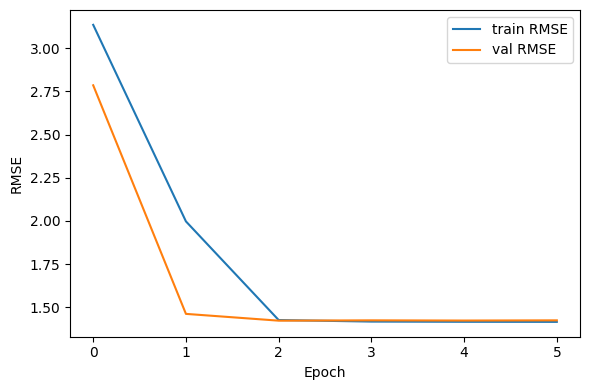

In [10]:
plt.figure(figsize=(6,4))
plt.plot(history.history['rmse'], label='train RMSE')
plt.plot(history.history['val_rmse'], label='val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
loss, rmse = model.evaluate(test_ds)
print(f"📉 Test RMSE: {rmse:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0302 - rmse: 1.4244
📉 Test RMSE: 1.4229


# **9. Simpan Model**

In [13]:
os.makedirs('model/cf', exist_ok=True)
model.export('model/cf', include_optimizer=False)
print("✅ SavedModel ready at model/cf")

!pip install tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model model/cf model/tfjs_model/
print("✅ TFJS model ready at model/tfjs_model/")

os.makedirs('model', exist_ok=True)
user_map = {k: int(v) for k, v in zip(user_encoder.classes_, user_encoder.transform(user_encoder.classes_))}
item_map = {k: int(v) for k, v in zip(item_encoder.classes_, item_encoder.transform(item_encoder.classes_))}
with open('model/user_encoder.json', 'w') as f:
    json.dump(user_map, f)
with open('model/item_encoder.json', 'w') as f:
    json.dump(item_map, f)
print("✅ Encoders saved to model/*.json")

!pip freeze > model/requirements.txt
print("✅ Saved requirements.txt")

Saved artifact at 'model/cf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None,), dtype=tf.int32, name='user_idx'), TensorSpec(shape=(None,), dtype=tf.int32, name='item_idx')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134305254282384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134305254277968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134305254280848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134305254278928: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ SavedModel ready at model/cf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not curren

In [14]:
import shutil

# Zip folder model menjadi cbf_encoder.zip
shutil.make_archive('model_cf', 'zip', 'model')

from google.colab import files
files.download('model_cf.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **10. Inference**

In [15]:
def predict_rating_py(user_id, item_id):
    """
    Prediksi rating single user-item menggunakan SavedModel + mapping JSON.
    """
    # Cek mapping
    if user_id not in user_map:
        raise ValueError(f"User '{user_id}' tidak dikenali.")
    if item_id not in item_map:
        raise ValueError(f"Item '{item_id}' tidak dikenali.")

    # Ambil index
    u_idx = np.array([user_map[user_id]], dtype=np.int32)
    i_idx = np.array([item_map[item_id]], dtype=np.int32)

    # Predict
    pred = model.predict({'user_idx': u_idx, 'item_idx': i_idx}, verbose=0)
    return float(pred[0])

# Contoh pemakaian
if __name__ == '__main__':
    test_user = df['user_id'].iloc[0]
    test_item = df['item_id'].iloc[0]
    rating = predict_rating_py(test_user, test_item)
    print(f"🎯 Predicted rating for '{test_user}' on '{test_item}': {rating:.2f}")

🎯 Predicted rating for 'user001' on 'Wisata Alam Datuk': 3.09


<ipython-input-15-5bd7846cc3e9>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(pred[0])
